# Dependencies

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import glob, os, random

# Load the Dataset

In [2]:
path = '/content/drive/MyDrive/archive/Garbage classification/Garbage classification'
img = glob.glob(os.path.join(path, '*/*.jpg'))

print(len(img))

2527


# Load Pre-trained model (Using Mobilenet v2) - Transfer Learning

In [3]:
module = ('mobilenet_v2', 224, 1280)
handle_base, pixels, FV_SIZE = module
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
img_size = (pixels, pixels)
print("USING {} with input size {} and output dimension {}".format(MODULE_HANDLE, img_size, FV_SIZE))

USING https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


Fine tuning the model

In [4]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=img_size + (3, ),
                                   output_shape=[FV_SIZE],
                                   trainable=True)

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rotation_range=40,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    path,
    target_size=img_size,
    batch_size=25,
    class_mode='categorical',
    subset='training',
    seed=0
)

val_generator = test_datagen.flow_from_directory(
    path,
    target_size=img_size,
    batch_size=25,
    class_mode='categorical',
    subset='validation',
    seed=0
)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)
print(len(labels))

Found 2527 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}
6


# Building the model

In [15]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 2587462 (9.87 MB)
Trainable params: 2553350 (9.74 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Training the model

In [19]:
history = model.fit(train_generator, epochs=50,
                    steps_per_epoch=30,
                    validation_data=val_generator)

model.save('model.h5')

Epoch 1/50
30/30 [==============================] - 37s 549ms/step - loss: 0.9093 - accuracy: 0.8667 - val_loss: 1.2165 - val_accuracy: 0.7171
Epoch 2/50
30/30 [==============================] - 17s 553ms/step - loss: 0.6455 - accuracy: 0.9147 - val_loss: 0.7516 - val_accuracy: 0.8725
Epoch 3/50
30/30 [==============================] - 15s 504ms/step - loss: 0.4972 - accuracy: 0.9413 - val_loss: 0.7186 - val_accuracy: 0.8566
Epoch 4/50
30/30 [==============================] - 14s 451ms/step - loss: 0.5309 - accuracy: 0.9188 - val_loss: 1.3904 - val_accuracy: 0.7490
Epoch 5/50
30/30 [==============================] - 14s 467ms/step - loss: 0.5679 - accuracy: 0.8987 - val_loss: 0.7963 - val_accuracy: 0.8287
Epoch 6/50
30/30 [==============================] - 15s 498ms/step - loss: 0.5891 - accuracy: 0.8982 - val_loss: 0.6401 - val_accuracy: 0.8845
Epoch 7/50
30/30 [==============================] - 16s 545ms/step - loss: 0.4766 - accuracy: 0.9173 - val_loss: 0.4248 - val_accuracy: 0.9323

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Graph

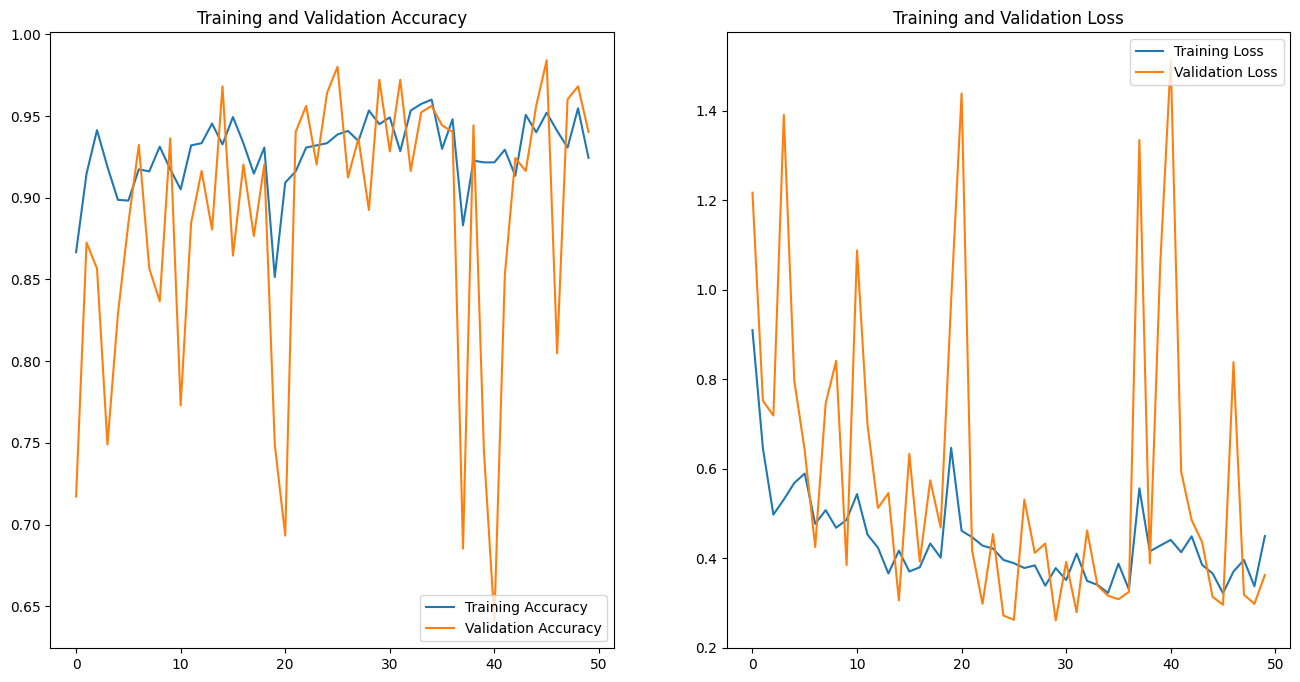

In [20]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs_range   = range(len(acc))
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
eval = model.evaluate(train_generator, return_dict=True, verbose=0)

print(eval)


{'loss': 0.5019273161888123, 'accuracy': 0.9066086411476135}
